In [1]:
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import pickle as pkl
import sys 
sys.path.insert(0,"/sdf/home/f/fascione/Trigger_Simulation")
from rawio.IO import getRawEvents
import cdms
import trigsim

In [2]:
fs = 625e3

In [7]:
ser='09210830_180510'

with open('SLAC_iZIPtemplate_'+ser+'_v1.pkl','rb') as file:  #CPD+PD2template_'+ser+'_v1
    trigger_template = pkl.load(file)
    print(trigger_template.keys())
chans=["PAS1Z2","PBS1Z2","PCS1Z2","PDS1Z2","PES1Z2","PFS1Z2","PAS2Z2","PBS2Z2","PCS2Z2","PDS2Z2","PES2Z2","PFS2Z2"]

dict_keys(['f_PAS1Z2', 'psd_PAS1Z2', 'f_fold_PAS1Z2', 'psd_fold_PAS1Z2', 'f_PBS1Z2', 'psd_PBS1Z2', 'f_fold_PBS1Z2', 'psd_fold_PBS1Z2', 'f_PCS1Z2', 'psd_PCS1Z2', 'f_fold_PCS1Z2', 'psd_fold_PCS1Z2', 'f_PDS1Z2', 'psd_PDS1Z2', 'f_fold_PDS1Z2', 'psd_fold_PDS1Z2', 'f_PES1Z2', 'psd_PES1Z2', 'f_fold_PES1Z2', 'psd_fold_PES1Z2', 'f_PFS1Z2', 'psd_PFS1Z2', 'f_fold_PFS1Z2', 'psd_fold_PFS1Z2', 'f_PAS2Z2', 'psd_PAS2Z2', 'f_fold_PAS2Z2', 'psd_fold_PAS2Z2', 'f_PBS2Z2', 'psd_PBS2Z2', 'f_fold_PBS2Z2', 'psd_fold_PBS2Z2', 'f_PCS2Z2', 'psd_PCS2Z2', 'f_fold_PCS2Z2', 'psd_fold_PCS2Z2', 'f_PDS2Z2', 'psd_PDS2Z2', 'f_fold_PDS2Z2', 'psd_fold_PDS2Z2', 'f_PES2Z2', 'psd_PES2Z2', 'f_fold_PES2Z2', 'psd_fold_PES2Z2', 'f_PFS2Z2', 'psd_PFS2Z2', 'f_fold_PFS2Z2', 'psd_fold_PFS2Z2', 'template_PAS1Z2', 'template_PBS1Z2', 'template_PCS1Z2', 'template_PDS1Z2', 'template_PES1Z2', 'template_PFS1Z2', 'template_PAS2Z2', 'template_PBS2Z2', 'template_PCS2Z2', 'template_PDS2Z2', 'template_PES2Z2', 'template_PFS2Z2'])


Note that the template is normalized to an amplitude of 1 and also has a baseline of 0.

The units of the PSD are $\frac{\mathrm{[ADC\ Bins]}^2}{\mathrm{[Hz]}}$.

/cvmfs/sft.cern.ch/lcg/views/LCG_98py3cu10/x86_64-centos7-gcc8-opt/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until
/cvmfs/sft.cern.ch/lcg/views/LCG_98py3cu10/x86_64-centos7-gcc8-opt/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  app.launch_new_instance()


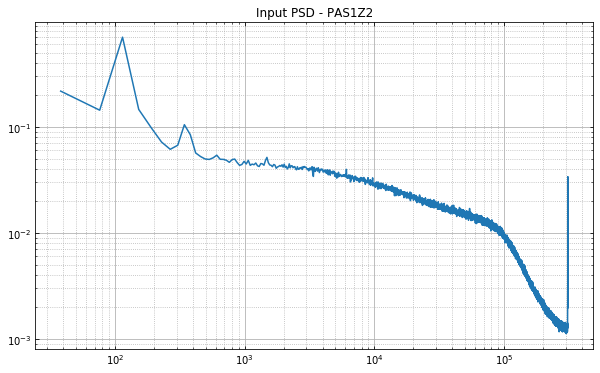

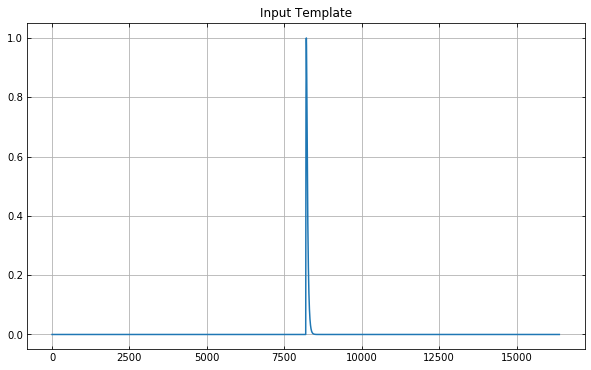

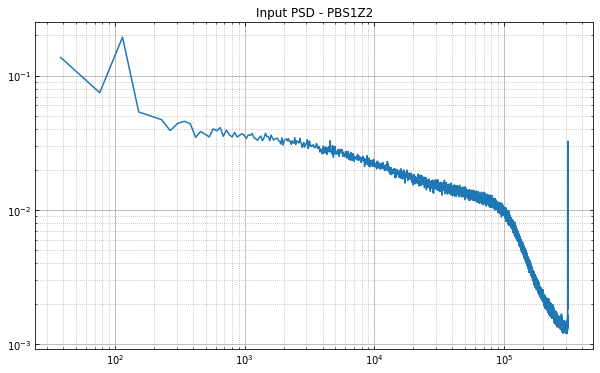

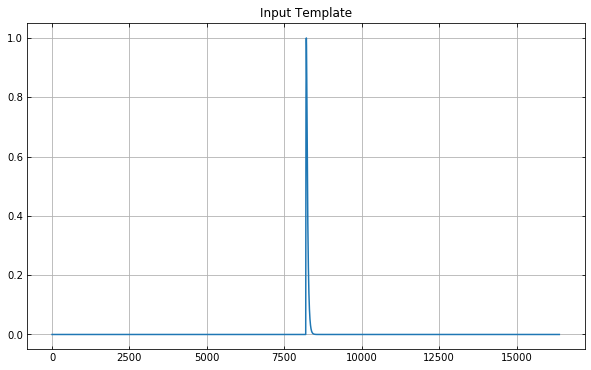

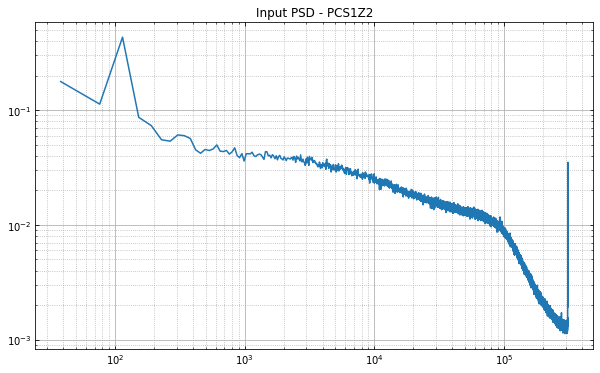

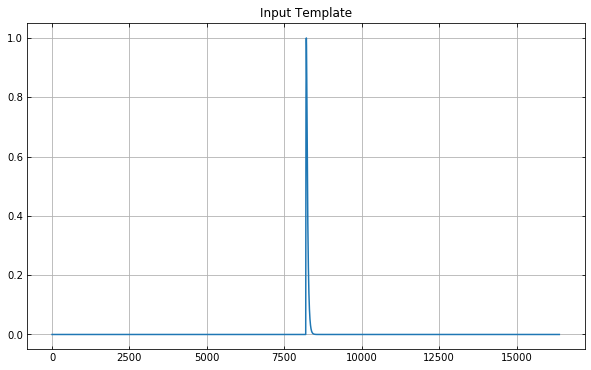

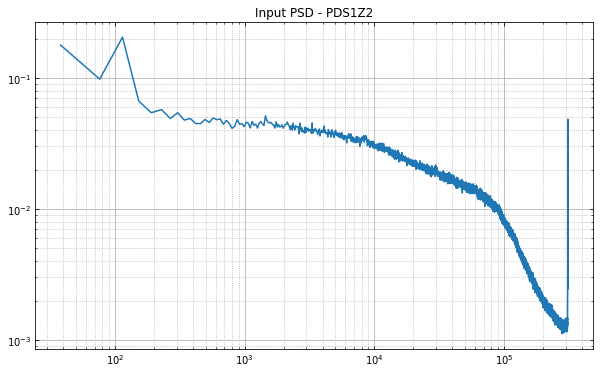

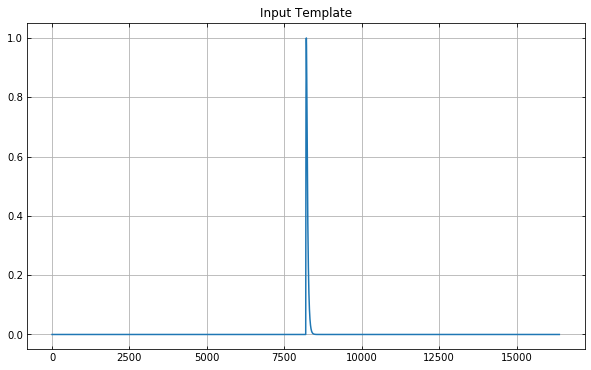

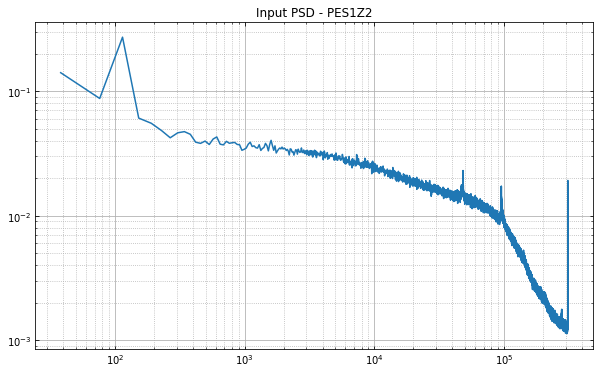

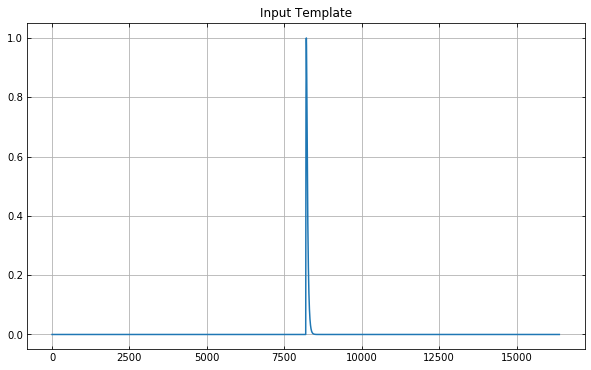

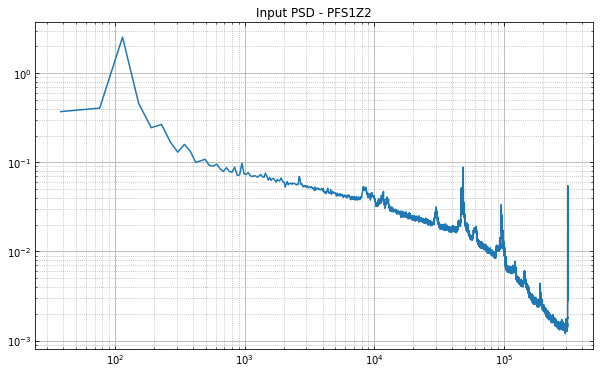

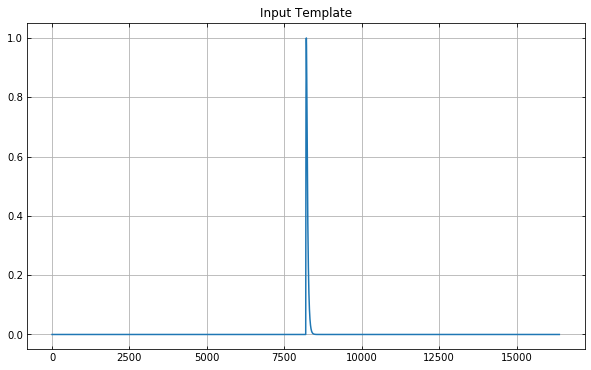

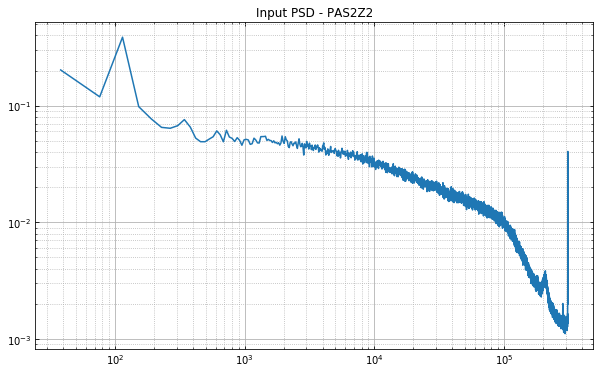

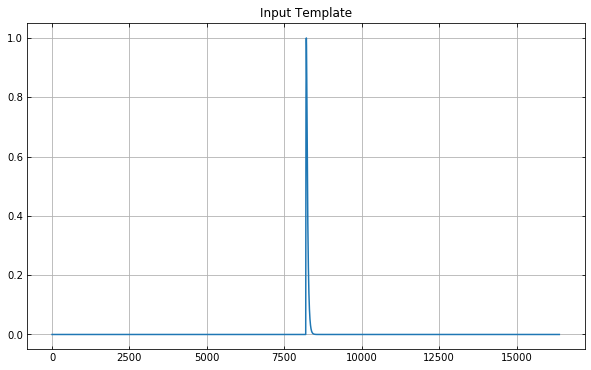

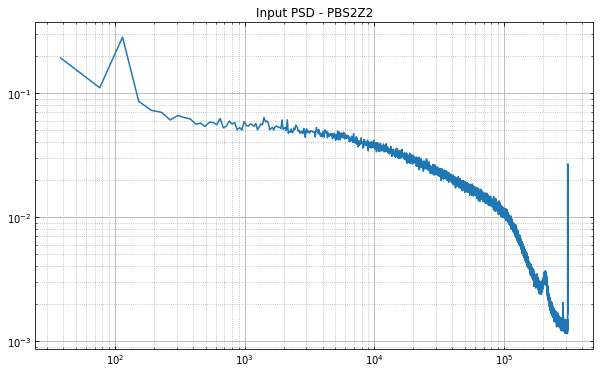

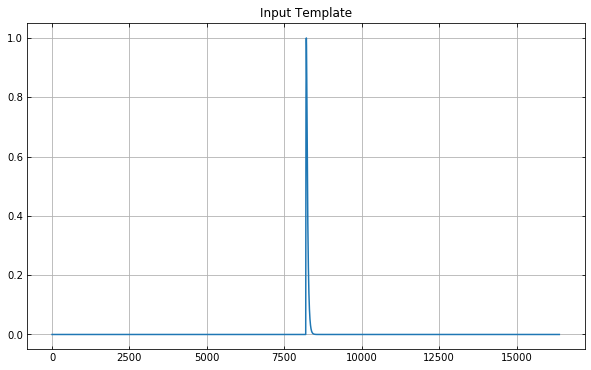

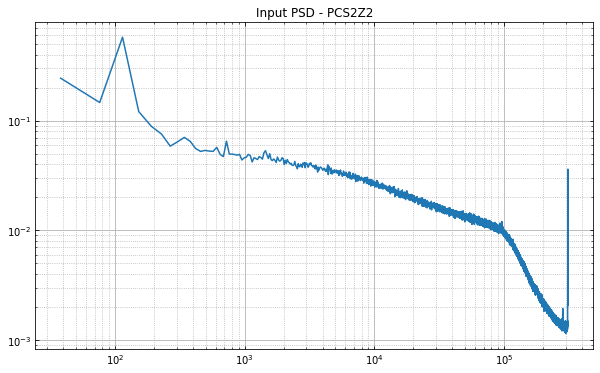

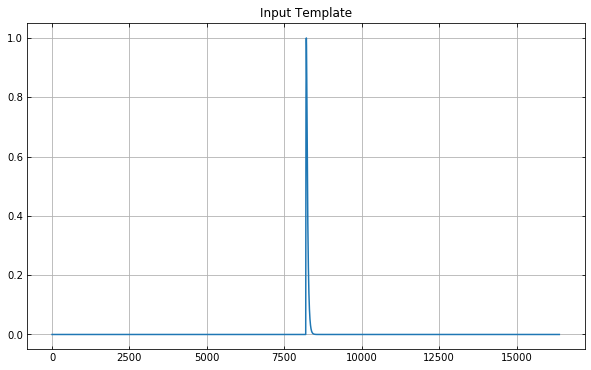

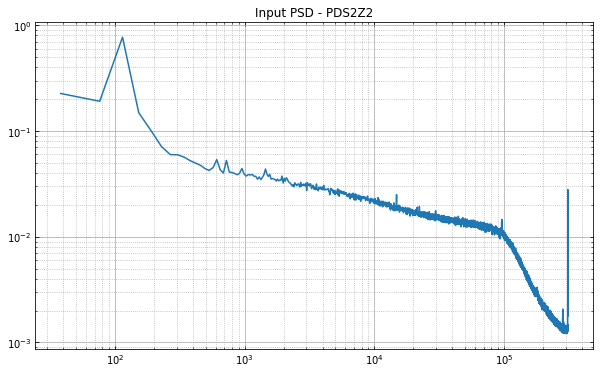

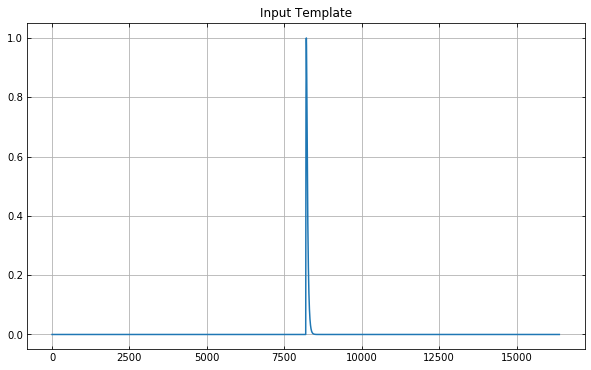

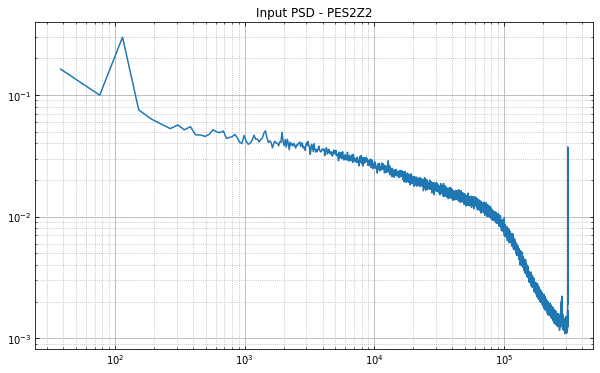

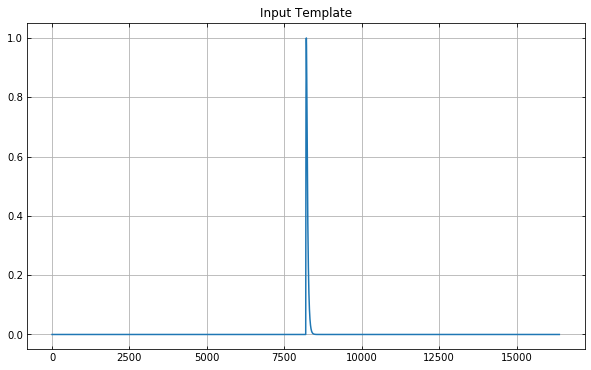

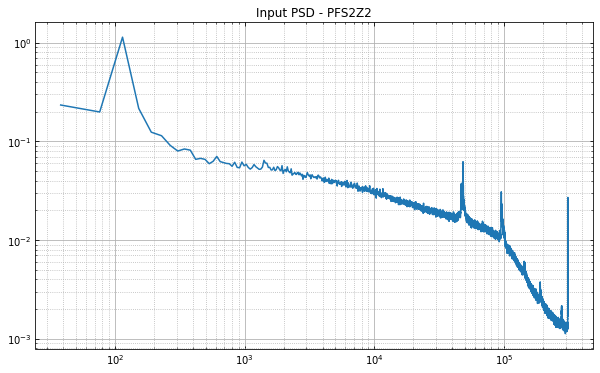

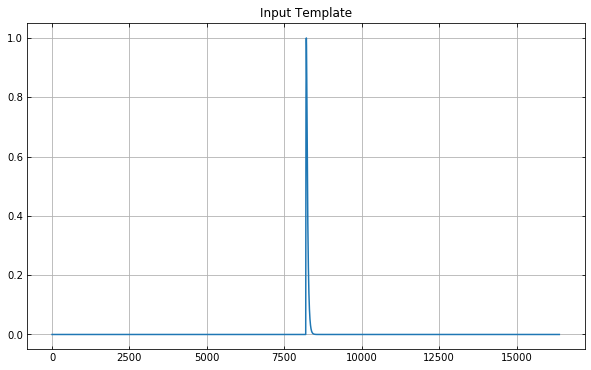

In [8]:

for chan in chans:
    fig, ax = plt.subplots(figsize=(10, 6))

    ax.plot(
        trigger_template['f_'+chan][trigger_template['f_'+chan] > 0],
        trigger_template['psd_'+chan][trigger_template['f_'+chan] > 0]**0.5,
    )
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_title("Input PSD - "+chan)
    ax.grid()
    ax.grid(which='minor', linestyle='dotted')
    ax.tick_params(which="both", direction='in', top=True, right=True)

    fig, ax = plt.subplots(figsize=(10, 6))

    ax.plot(trigger_template['template_'+chan])
    ax.set_title("Input Template");
    ax.grid()
    ax.tick_params(which="both", direction='in', top=True, right=True)

Load the traces using `scdmsPyTools`, then use `trigsim` to run the trigger simulation code. NOT Necessary for just FIR generation

In [5]:
'''
event_dict = getRawEvents(
    "/gpfs/slac/staas/fs1/g/supercdms/data/CDMS/CUTE/R11/Raw/23191217_1023",
    "23191217_1023_F0001.mid.gz",
    channelList=['PES1'],
    detectorList=[5],
    outputFormat=3,
)
'''
event_dict = getRawEvents(
    "/gpfs/slac/staas/fs1/g/supercdms/data/CDMS/CUTE/R20/Raw/",
    ser,
    #eventNumbers = [1340261],
    channelList=[chan[0:4]],
    outputFormat=3,
)

No file found. Check your input!


In [9]:
chan='PAS1Z2'

In [16]:
input_PSDs = []
for chan in chans:
    input_PSDs = input_PSDs+[trigger_template['psd_'+chan]]
    
input_PSDs = input_PSDs + [np.ones(4 * len(trigger_template['psd_'+chan]))] * 4  


input_pulse_shapes = []
for chan in chans:
    input_pulse_shapes = input_pulse_shapes+[trigger_template['template_'+chan]]
    
input_pulse_shapes = input_pulse_shapes + [np.zeros(4 * trigger_template['template_'+chan].shape[0])] * 4 


In [18]:

#input_PSDs = [trigger_template['psd_'+chan]] * 12 + [np.ones(4 * len(trigger_template['psd_'+chan]))] * 4
#input_pulse_shapes = [trigger_template['template_'+chan]] * 12 + [np.zeros(4 * trigger_template['template_'+chan].shape[0])] * 4

raw_LC_coeffs = np.zeros((4, 16))
which_channel = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
for ii in which_channel:
    raw_LC_coeffs[0, ii] = 1 # only one phonon channel
LC_coeffs = trigsim.scale_max(raw_LC_coeffs, bits=8, axis=1)
TrL_requires = np.zeros((8, 16), dtype=bool)
TrL_vetos = np.zeros((8, 16), dtype=bool)

trig = trigsim.Trigger(
    bits_phonon=16,
    bits_charge=16,
    phonon_DF_R=16,
    phonon_DF_N=3,
    phonon_DF_M=1,
    phonon_start=0,
    charge_DF_R=64,
    charge_DF_N=3,
    charge_DF_M=1,
    charge_start=0,
    LC_coeffs=LC_coeffs,
    LC_bits_out=46,
    LC_bits_coeff=8,
    LC_discard_MSBs=[0, 0, 0, 0],
    FIR_coeffs=np.zeros((4, 1024), 'i8'),
    FIR_bits_out=32,
    FIR_bits_coeff=16,
    FIR_discard_MSBs=[2, 2, 0, 0],
    ThL_selectors=np.array([0, 1, 2, 3, 1, 1, 2, 3], dtype='uint'),
    ThL_activation_thresholds=(2**15 - 1) * np.ones(8, int),
    ThL_deactivation_thresholds=np.zeros(8, int),
    PS_max_window_lengths=(2**31 - 1) * np.ones(4, dtype='uint'),
    PS_saturated_pulse_offsets=np.zeros(4, dtype='uint'),
    TrL_selectors=np.array([0, 1, 2, 3, 1, 1, 2, 3], dtype='uint'),
    TrL_enables=np.array([1, 0, 0, 0, 0, 0, 0, 0], dtype=bool),
    TrL_requires=TrL_requires,
    TrL_vetos=TrL_vetos,
    TrL_prescales=np.ones(8, dtype='float'),
)

Calculate the FIR coefficients, which would be loaded to the FPGA.

In [21]:
OF_coeffs = trig.build_OF_coeffs(input_PSDs, input_pulse_shapes)
trig.set_FIR_coeffs(OF_coeffs)
print(OF_coeffs)
print(type(OF_coeffs))
which_channel = 0
print(len(OF_coeffs[which_channel]))
print(min(OF_coeffs[1]))

[[ 20 -76 -15 ...  -1  42   5]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]]
<class 'numpy.ndarray'>
1024
0


Calculate the resolution of the trigger (units are arbitrary)

In [22]:
print((input_pulse_shapes))
resolution = trig.resolution(input_PSDs, deltaT_phonon=1 / fs)[which_channel]
print(resolution*5)
trig.ThL.ThLs[0].set_thresholds(np.int64(5 * resolution), 0)

[array([0.00000000e+000, 0.00000000e+000, 0.00000000e+000, ...,
       9.71292300e-104, 9.43443561e-104, 9.16393296e-104]), array([0.00000000e+000, 0.00000000e+000, 0.00000000e+000, ...,
       9.71292300e-104, 9.43443561e-104, 9.16393296e-104]), array([0.00000000e+000, 0.00000000e+000, 0.00000000e+000, ...,
       9.71292300e-104, 9.43443561e-104, 9.16393296e-104]), array([0.00000000e+000, 0.00000000e+000, 0.00000000e+000, ...,
       9.71292300e-104, 9.43443561e-104, 9.16393296e-104]), array([0.00000000e+000, 0.00000000e+000, 0.00000000e+000, ...,
       9.71292300e-104, 9.43443561e-104, 9.16393296e-104]), array([0.00000000e+000, 0.00000000e+000, 0.00000000e+000, ...,
       9.71292300e-104, 9.43443561e-104, 9.16393296e-104]), array([0.00000000e+000, 0.00000000e+000, 0.00000000e+000, ...,
       9.71292300e-104, 9.43443561e-104, 9.16393296e-104]), array([0.00000000e+000, 0.00000000e+000, 0.00000000e+000, ...,
       9.71292300e-104, 9.43443561e-104, 9.16393296e-104]), array([0.000000

In [23]:
tcon = trigsim.Trig_Controls(trig)
tcon.configure_trigger("/Detectors/Det02/Settings/L1Trigger/DCRC0", "odb_SLAC_iZIP")

Now run "odbedit -c @odb_SLAC_iZIP" to actually load these settings into the DCRC
Note: every ODB key change will set off a full readback by the DCRC driver.  This will take a few minutes to complete unless you stop the DCRC driver first and restart it afterwards.


In [24]:
plt.plot(event_dict['Z2']['p'][0,0])

NameError: name 'event_dict' is not defined

Send the traces through the pipeline to get the FIR filtered trace.

In [14]:
x = event_dict["Z1"]["p"][0, 0]

k = 12 # to match data, this should be 12 - this can change from dataset to dataset

input_traces = [(x[k:] - 32768).astype('int64')] + [np.zeros(len(x[k:]),dtype='int64')]*11 + \
               [np.zeros(4*len(x[k:]),dtype='int64')]*4


trig.reset()

pipe = trigsim.pipeline(
    trig.DF,
    trig.LC,
    trig.LC_trunc,
    trig.FIR,
    trig.FIR_trunc,
)

fir_out = pipe.send(input_traces)

Use the Trigger Simulation code to get the amplitudes passed to the L2 Trigger

In [15]:
trig.reset()
output = trig.send(input_traces)

In [16]:
output["peak time"] # times for each event in trace

array([ 8100, 16519, 17703, 18071, 20103, 20231, 21255, 21399, 21895,
       22375, 23143, 24375, 25367, 25591, 26471, 26935, 27479, 28711,
       29143, 32311], dtype=int32)

In [17]:
output["max amp"] # amplitudes for each event in trace

array([  428,   661,   420,   380,   355,   386,   655,   470,  1330,
         353,   566, 31341,   336,   677,   474,   841,   622,   488,
         348,   553])

Note that the first few amplitudes are "junk" due to edge effects. We can get the "good" part of the FIR filtered trace by truncating the correct number of bins from the beginning of the trace.

In [18]:
bins_to_keep = (len(x) - k)//16 - 1024

fir_good = fir_out[0, -bins_to_keep:]

We can now find the largest magnitude amplitude in the valid part of the FIR filtered trace.

In [19]:
fir_good.max()

31341

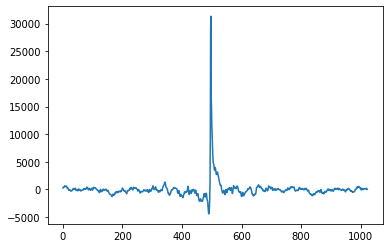

In [20]:
plt.plot(fir_good)
#plt.ylim(-4000,8000)

## Running the Trigger Simulation with `rqpy`

In [1]:
import rqpy as rp

/opt/rh/rh-python36/root/usr/lib64/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for DataWriter already registered; second conversion method ignored.
  return f(*args, **kwds)
/opt/rh/rh-python36/root/usr/lib64/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for DataReader already registered; second conversion method ignored.
  return f(*args, **kwds)


Use the `rqpy` wrapper of `scdmsPyTools` IO functions to load the data from a dump.

In [ ]:
channels=['PES1']
det=["Z1"]

x, info_dict = rp.io.get_traces_midgz(
    '/gpfs/slac/staas/fs1/g/supercdms/users/ryanu/notebooks/R14/Cute_R14/23200301_140601/23200301_140601_F0001.mid.gz', #'/galbadata/SLAC/Run47/Run47_DM_search/09181201_1525/09181201_1525_F0100.mid.gz',
    channels,
    det,
    convtoamps=1,
    lgcreturndict=True,
)

Initialize the `TrigSim` class. Note the optional arguments of the initialization of the class.

In [21]:
rp.sim.TrigSim?

Init signature: rp.sim.TrigSim(psd, template, fs, which_channel=0, fir_bits_out=32, fir_discard_msbs=4)
Docstring:     
Class for setting up the DCRC FIR filter trigger simulation.

Attributes
----------
_Trigger : Object
    The `trigsim.Trigger` object which is used to build and run the FIR filter.
input_psds : list
    The input power spectral density for the data, re-arranged for input into the FIR
    filter code.
input_pulse_shapes : list
    The input pulse shape to use for the FIR filter, normalized to have a height of 1,
    and re-arranged for input into the FIR filter code.
fs : float
    The digitization rate of the data in Hz.
of_coeffs : ndarray
    The coefficients of the FIR filter that will be applied to the downsampled
    data.
_resolution : list
    The calculated resolution of the FIR filter.
convtoadcbins : float
    The conversion factor for expressing FIR filter amplitudes in units of ADC bins.
Init docstring:
Initialization of the TrigSim class.

Parameters
---

In [22]:
psds = trigger_template['psd_PES1Z1']
'''
psds = np.append(psds,trigger_template['psd_PBS2Z2'])
psds = np.append(psds,trigger_template['psd_PFS2Z2'])
psds = np.resize(psds,(3,16384))
'''
pulse_template = trigger_template['template_PES1Z1']
'''
pulse_template = np.append(pulse_template,trigger_template['template_PBS2Z2'])
pulse_template = np.append(pulse_template,trigger_template['template_PFS2Z2'])
pulse_template = np.resize(pulse_template,(3,16384))
print(pulse_template.shape)
'''
TS = rp.sim.TrigSim(
    psds,
    pulse_template,
    fs,
    fir_discard_msbs = 2,
    which_channel= [0,1,2]
)

Run the trigger and print the amplitude from the simulation.

In [26]:
amp, t0, fir_nodelay, fir_trace = TS.trigger(x[1, 0], k=12)

amp, t0

IndexError: too many indices for array

Check against the amplitude recorded by the DCRC

In [21]:
info_dict['triggeramp'][1]

350435

Note that I don't set a threshold here. Instead, I return the largest amplitude in the trace, and I leave it up to the user to apply a cut offline on some threshold.

There are also a couple other useful methods/attributes included in the `rqpy.sim.TrigSim` class.

In [15]:
TS.convtoadcbins # conversion from the arbitrary units to ADC bins (multiply by this factor)

0.10456622614219693

In [6]:
TS.resolution() # method for calculating the resolution of the FIR filter in the arbitrary units.

array([407.37189226,   0.        ,   0.        ,   0.        ])

I have also written docstrings for all the functions in `rqpy`, so it is highly recommended to read the documentation.

In [31]:
TS.trigger?

Signature: TS.trigger(x, k=12)
Docstring:
Method for sending a trace to run the trigger simulation on.

Parameters
----------
x : ndarray
    The input array to run the FIR filter on. Can be a 1 or 2D ndarray in units of 
    ADC bins. Should be 2D if multiple channels are being triggered on, where the ndarray
    should be all of the available channels.
k : int, optional
    The bin number to start the FIR filter at. Since the filter downsamples the data
    by a factor of 16, the starting bin has a small effect on the calculated amplitude.

Returns
-------
triggeramp : int
    The trigger amplitude of the pulse as calculated by the FIR filter, in the arbitrary 
    units of the filter. Taken from the maximum amplitude in the trace.
triggertime : float
    The time of the triggered pulse as calculated by the FIR filter, in s. Taken as the bin
    number of the maximum amplitude within the valid part of the trace divided by the
    downsampled digitization rate.
fir_nodelay : float
   

In [ ]:
trig.ThL.ThLs[0].set_thresholds(np.int64(5 * resolution), 0)